<a href="https://colab.research.google.com/github/piyushgoel997/MutationClassification/blob/master/Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import statements and declaring some global variables


In [1]:
import time
import random

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from keras.utils import plot_model
from sklearn.metrics import roc_curve, auc, precision_recall_curve, accuracy_score
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Conv1D, BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping

data_url = "https://raw.githubusercontent.com/piyushgoel997/MutationClassification/master/data.csv"
epochs = 1000
batch_size = 8192

# to stop the model from overfitting on the training data.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=50, verbose=2, mode="min", restore_best_weights=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


Load and represent data in a one-hot encoded matrix form to be easily able to train the model.

Matrix Dimentions: Number of examples, Number of Features (in this case, the length of the sequence of Amino Acids), Number of possible feature values (20 possible Amino Acids)

In [2]:
def get_aa_encoder():
    """
    One-hot encoding indices for the 20 possible amino acids.
    :return: the dictionary mapping amino acid to index in the one-hot encoding.
    """
    acids = "ARNDCEQGHILKMFPSTWYV"
    indices = {}
    i = 0
    for a in acids:
        indices[a] = i
        i += 1
    return indices


def make_matrix(seq, alt):
    """
    makes a matrix where each of the 51 features correspond to the amino acid at
    that position in the sequence after the one-hot encoding using the indices
    provided. Also puts a -1 at in the middle most feature at the position
    corresponding to the alt amino acid.
    :param seq: the sequence to be encoded.
    :param alt: the alternate amino acid
    :return: the resultant encoded matrix (51 X 20)
    """
    indices = get_aa_encoder()
    matrix = np.zeros((len(indices), len(seq)))
    i = 0
    for s in seq:
        matrix[indices[s]][i] = 1
        i += 1
    matrix[indices[alt]][int(len(seq) / 2)] = -1
    return matrix.T


def map_description(description):
    map = {'Benign': 0, 'Benign/Likely benign': 0, 'Likely benign': 0,
           'Likely pathogenic': 1, 'Pathogenic': 1, 'Pathogenic/Likely pathogenic': 1}
    return map[description]


def shuffle_together(arrays):
    ind = list(range(len(arrays[0])))
    random.shuffle(ind)
    return [X[ind] for X in arrays]


X = []
Y = []
gene_ids = []
mutations = pd.read_csv(data_url)

for _, row in mutations.iterrows():
    X.append(make_matrix(row["REF_SEQ"], row["ALT_AA"]))
    Y.append(map_description(row["DESCRIPTION"]))
    gene_ids.append(row["UNIPROT_ACCESSION"])

X = np.array(X)
Y = np.array(Y)

X, Y, gene_ids = shuffle_together([X, Y, np.array(gene_ids)])
gene_ids = list(gene_ids)

print("Input shape", X.shape, "\nOutput shape", Y.shape)
print("Count of Pathogenic examples", np.count_nonzero(Y == 1))
print("Count of Benign examples", np.count_nonzero(Y == 0))
print("Total number of genes present", len(set(gene_ids)))

Input shape (229502, 51, 20) 
Output shape (229502,)
Count of Pathogenic examples 41045
Count of Benign examples 188457
Total number of genes present 8203


Helper methods to be initialize and comple the model, and provide different evaluation metrics like accuracy, loss, ROC curve, ROC AUC, PRC curve, etc.

In [0]:
def get_model(h=0):
    """
    make, compile and return the model
    :param h: The number of hidden layers with 64 channels to be added
    :return: the model
    """
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation="relu"))
    for _ in range(h):
        model.add(Conv1D(64, kernel_size=5, activation="relu"))
        model.add(BatchNormalization())
    model.add(Conv1D(32, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(1, kernel_size=1, activation='sigmoid'))
    model.add(BatchNormalization())
    model.add(GlobalMaxPooling1D())
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return model


def get_model2(h):
    """
    make, compile and return the model. Incresed the kernel size.
    :param h: The number of hidden layers with 64 channels to be added
    :return: the model
    """
    model = Sequential()
    model.add(Conv1D(32, kernel_size=5, activation="relu"))
    for _ in range(h):
        model.add(Conv1D(64, kernel_size=7, activation="relu"))
        model.add(BatchNormalization())
    model.add(Conv1D(32, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(1, kernel_size=1, activation='sigmoid'))
    model.add(BatchNormalization())
    model.add(GlobalMaxPooling1D())
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return model


def k_fold_cross_validation(h, X, Y, k=10, epochs=20, batch_size=512, callbacks=None, get_model=get_model):
    """
    Make the model, train it, and validate it using k-fold cross validation.
    :param h: The number of hidden layers with 64 channels to be added in the model.
    :param X: input to the model.
    :param Y: expected outputs of the model.
    :return: average accuracy, avg auc, k roc curve coordinates, k prc curve coordinates.
    """
    avg_accuracy_tain = 0
    avg_accuracy_val = 0
    avg_loss_train = 0
    avg_loss_val = 0
    avg_roc_auc = 0
    roc_curves = []
    prc_curves = []
    summary = []
    results = ""
    for i in range(k):
        start_time = time.time()
        model = get_model(h)
        print("========Cross Validation:", str(i + 1) + "/" + str(k) + "=========")
        start = int(X.shape[0] * (i / k))
        end = int(X.shape[0] * ((i + 1) / k))
        test_data = X[start:end]
        y_test = Y[start:end]
        train_data = np.concatenate([X[:start], X[end:]])
        y_train = np.concatenate([Y[:start], Y[end:]])
        history = model.fit(train_data, y_train, validation_data=(test_data, y_test), callbacks=callbacks, batch_size=batch_size, epochs=epochs, verbose=2)
        test_out = model.predict(test_data)
        if results == "":
            results = test_out
        else:
            results = np.concatenate([results, test_out])
        fpr, tpr, _ = roc_curve(y_test, test_out)
        roc_curves.append((fpr, tpr))
        avg_roc_auc += auc(fpr, tpr)
        p, r, _ = precision_recall_curve(y_test, test_out)
        prc_curves.append((r, p))
        avg_accuracy_tain += history.history['accuracy'][-1]
        avg_accuracy_val += history.history['val_accuracy'][-1]
        avg_loss_train += history.history['loss'][-1]
        avg_loss_val += history.history['val_loss'][-1]
        
        if len(summary) == 0: model.summary(print_fn=lambda x: summary.append(x))

        del model

        plt.plot(history.history['accuracy'], label="Train Acc")
        plt.plot(history.history['val_accuracy'], label="Val Acc")
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label="Train Loss")
        plt.plot(history.history['val_loss'], label="Val Loss")
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()
        plt.show()

        print("Time taken", str(time.time() - start_time))
        # print("Train Accuracy", history.history['accuracy'][-1], "\nVal Accuracy", history.history['val_accuracy'][-1])

    return {"avg_accuracy_train": avg_accuracy_tain / k, "avg_accuracy_val": avg_accuracy_val / k,
            "avg_loss_train": avg_loss_train / k, "avg_loss_val": avg_loss_val / k,
            "avg_roc_auc": avg_roc_auc / k, "roc": roc_curves, "prc": prc_curves,
            "model_summary": "\n".join(summary), "predictions": results}


def genes_with_both(gene_ids, Y, pred):
    """
    Gets the accuracy of the predictions on genes containing both pathogenic and benign mutations.
    Also the number of genes conatining both, and the number of examples belonging to those genes.
    :param gene_ids: list conataining the ids of genes.
    :param Y: 1D array or list contating the true outputs.
    :param pred: 1D array or list contating the prediction made by the model.
    :return: a dictionary containing all the measures.
    """
    patho = set()
    benign = set()
    for i in range(len(gene_ids)):
        if Y[i] == 1:
            patho.add(gene_ids[i])
        else:
            benign.add(gene_ids[i])
    intersec = patho.intersection(benign)
    y_true = []
    y_pred = []
    for y, y_, id in zip(Y, pred, gene_ids):
        if id in intersec:
            y_true.append(y)
            y_pred.append(y_)
    return {"Accuracy": accuracy_score(y_true, [round(p[0]) for p in y_pred]), "patho_ct": sum(y_true) ,"total": len(y_true), "genes_with_both": len(intersec)}


def draw_pdf(Y, pred):
    """
    Draws pdf of both the classes based on the model predictions.
    :param Y: 1D array or list contating the true outputs.
    :param pred: 1D array or list contating the prediction made by the model.
    """
    patho = []
    benign = []
    for y, y_ in zip(Y, pred):
        if y == 1:
            patho.append(y_)
        else:
          benign.append(y_)
    sns.distplot(benign,hist = False, kde=True, kde_kws = {"shade": True, "linewidth": 2}, label="Benign, Y=0")
    sns.distplot(patho,hist = False, kde=True, kde_kws = {"shade": True, "linewidth": 2}, label="Pathogenic, Y=1")
    plt.title("PDFs")
    plt.show()

Training and evaluating a few different models (with different number of hidden layers) and chosing the best one.

===========Next model type============
==========Starting for h = 1==========
========Cross Validation: 1/5=========
Epoch 1/1000
23/23 - 2s - loss: 1.2173 - accuracy: 0.1788 - val_loss: 0.3050 - val_accuracy: 0.1791
Epoch 2/1000
23/23 - 1s - loss: 0.5400 - accuracy: 0.1788 - val_loss: 0.2811 - val_accuracy: 0.1791
Epoch 3/1000
23/23 - 1s - loss: 0.3140 - accuracy: 0.1792 - val_loss: 0.2665 - val_accuracy: 0.1801
Epoch 4/1000
23/23 - 1s - loss: 0.2416 - accuracy: 0.6616 - val_loss: 0.2338 - val_accuracy: 0.8205
Epoch 5/1000
23/23 - 1s - loss: 0.2181 - accuracy: 0.8212 - val_loss: 0.1970 - val_accuracy: 0.8209
Epoch 6/1000
23/23 - 1s - loss: 0.2051 - accuracy: 0.8212 - val_loss: 0.1695 - val_accuracy: 0.8209
Epoch 7/1000
23/23 - 1s - loss: 0.1952 - accuracy: 0.8212 - val_loss: 0.1535 - val_accuracy: 0.8209
Epoch 8/1000
23/23 - 1s - loss: 0.1870 - accuracy: 0.8212 - val_loss: 0.1473 - val_accuracy: 0.8209
Epoch 9/1000
23/23 - 1s - loss: 0.1801 - accuracy: 0.8212 - val_loss: 0.1475 - val_

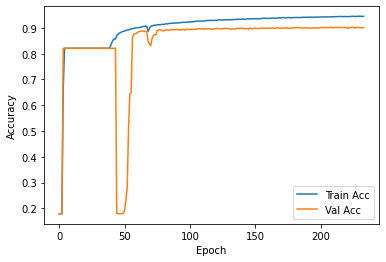

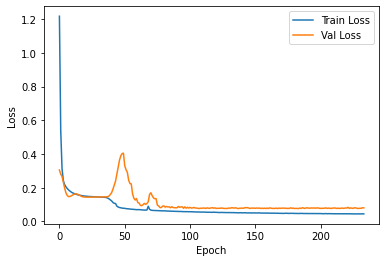

Time taken 267.13284707069397
========Cross Validation: 2/5=========
Epoch 1/1000
23/23 - 1s - loss: 1.2926 - accuracy: 0.1792 - val_loss: 0.3089 - val_accuracy: 0.1773
Epoch 2/1000
23/23 - 1s - loss: 0.5858 - accuracy: 0.1792 - val_loss: 0.2945 - val_accuracy: 0.1773
Epoch 3/1000
23/23 - 1s - loss: 0.3759 - accuracy: 0.1792 - val_loss: 0.2726 - val_accuracy: 0.1773
Epoch 4/1000
23/23 - 1s - loss: 0.2794 - accuracy: 0.2146 - val_loss: 0.2390 - val_accuracy: 0.8134
Epoch 5/1000
23/23 - 1s - loss: 0.2318 - accuracy: 0.8007 - val_loss: 0.2055 - val_accuracy: 0.8227
Epoch 6/1000
23/23 - 1s - loss: 0.2138 - accuracy: 0.8208 - val_loss: 0.1785 - val_accuracy: 0.8227
Epoch 7/1000
23/23 - 1s - loss: 0.2030 - accuracy: 0.8208 - val_loss: 0.1618 - val_accuracy: 0.8227
Epoch 8/1000
23/23 - 1s - loss: 0.1948 - accuracy: 0.8208 - val_loss: 0.1527 - val_accuracy: 0.8227
Epoch 9/1000
23/23 - 1s - loss: 0.1880 - accuracy: 0.8208 - val_loss: 0.1484 - val_accuracy: 0.8227
Epoch 10/1000
23/23 - 1s - loss

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


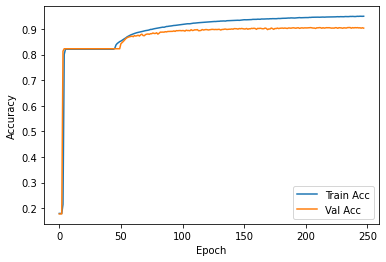

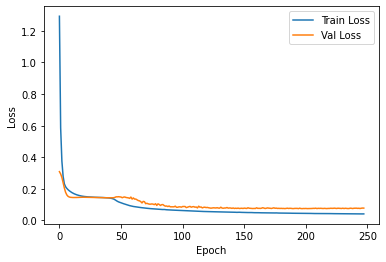

Time taken 278.269314289093
========Cross Validation: 3/5=========
Epoch 1/1000
23/23 - 2s - loss: 1.0549 - accuracy: 0.1786 - val_loss: 0.3249 - val_accuracy: 0.1799
Epoch 2/1000
23/23 - 1s - loss: 0.4587 - accuracy: 0.1786 - val_loss: 0.3268 - val_accuracy: 0.1799
Epoch 3/1000
23/23 - 1s - loss: 0.3188 - accuracy: 0.1786 - val_loss: 0.3103 - val_accuracy: 0.1799
Epoch 4/1000
23/23 - 1s - loss: 0.2343 - accuracy: 0.6637 - val_loss: 0.2840 - val_accuracy: 0.1799
Epoch 5/1000
23/23 - 1s - loss: 0.1988 - accuracy: 0.8214 - val_loss: 0.2517 - val_accuracy: 0.3380
Epoch 6/1000
23/23 - 1s - loss: 0.1865 - accuracy: 0.8214 - val_loss: 0.2234 - val_accuracy: 0.8201
Epoch 7/1000
23/23 - 1s - loss: 0.1791 - accuracy: 0.8214 - val_loss: 0.2019 - val_accuracy: 0.8201
Epoch 8/1000
23/23 - 1s - loss: 0.1734 - accuracy: 0.8214 - val_loss: 0.1862 - val_accuracy: 0.8201
Epoch 9/1000
23/23 - 1s - loss: 0.1691 - accuracy: 0.8214 - val_loss: 0.1749 - val_accuracy: 0.8201
Epoch 10/1000
23/23 - 1s - loss: 

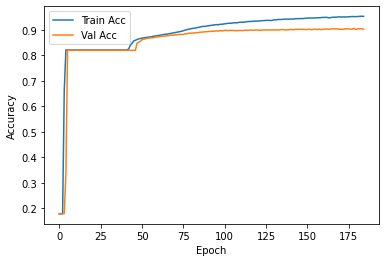

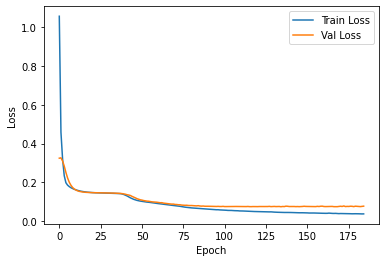

Time taken 208.69299125671387
========Cross Validation: 4/5=========
Epoch 1/1000
23/23 - 1s - loss: 1.0797 - accuracy: 0.1790 - val_loss: 0.2864 - val_accuracy: 0.1783
Epoch 2/1000
23/23 - 1s - loss: 0.4568 - accuracy: 0.1790 - val_loss: 0.2907 - val_accuracy: 0.1783
Epoch 3/1000
23/23 - 1s - loss: 0.2972 - accuracy: 0.2152 - val_loss: 0.2842 - val_accuracy: 0.1783
Epoch 4/1000
23/23 - 1s - loss: 0.2155 - accuracy: 0.8019 - val_loss: 0.2589 - val_accuracy: 0.1791
Epoch 5/1000
23/23 - 1s - loss: 0.1833 - accuracy: 0.8210 - val_loss: 0.2255 - val_accuracy: 0.8217
Epoch 6/1000
23/23 - 1s - loss: 0.1727 - accuracy: 0.8210 - val_loss: 0.1962 - val_accuracy: 0.8217
Epoch 7/1000
23/23 - 1s - loss: 0.1664 - accuracy: 0.8210 - val_loss: 0.1754 - val_accuracy: 0.8217
Epoch 8/1000
23/23 - 1s - loss: 0.1623 - accuracy: 0.8210 - val_loss: 0.1615 - val_accuracy: 0.8217
Epoch 9/1000
23/23 - 1s - loss: 0.1590 - accuracy: 0.8210 - val_loss: 0.1529 - val_accuracy: 0.8217
Epoch 10/1000
23/23 - 1s - loss

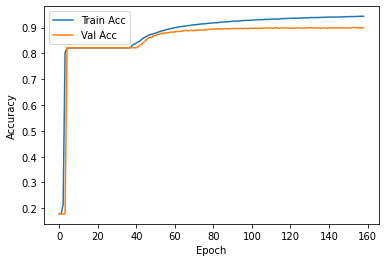

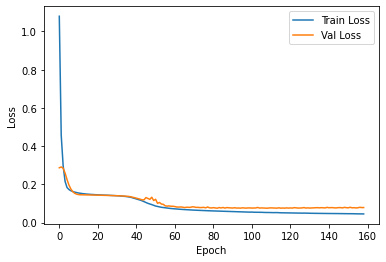

Time taken 179.04063367843628
========Cross Validation: 5/5=========
Epoch 1/1000
23/23 - 1s - loss: 1.3289 - accuracy: 0.1787 - val_loss: 0.3152 - val_accuracy: 0.1796
Epoch 2/1000
23/23 - 1s - loss: 0.5707 - accuracy: 0.1787 - val_loss: 0.2990 - val_accuracy: 0.1796
Epoch 3/1000
23/23 - 1s - loss: 0.3653 - accuracy: 0.1787 - val_loss: 0.2736 - val_accuracy: 0.1797
Epoch 4/1000
23/23 - 1s - loss: 0.2925 - accuracy: 0.1787 - val_loss: 0.2432 - val_accuracy: 0.7181
Epoch 5/1000
23/23 - 1s - loss: 0.2642 - accuracy: 0.1859 - val_loss: 0.2177 - val_accuracy: 0.8202
Epoch 6/1000
23/23 - 1s - loss: 0.2459 - accuracy: 0.6677 - val_loss: 0.1994 - val_accuracy: 0.8204
Epoch 7/1000
23/23 - 1s - loss: 0.2318 - accuracy: 0.8213 - val_loss: 0.1873 - val_accuracy: 0.8204
Epoch 8/1000
23/23 - 1s - loss: 0.2200 - accuracy: 0.8213 - val_loss: 0.1791 - val_accuracy: 0.8204
Epoch 9/1000
23/23 - 1s - loss: 0.2099 - accuracy: 0.8213 - val_loss: 0.1735 - val_accuracy: 0.8204
Epoch 10/1000
23/23 - 1s - loss

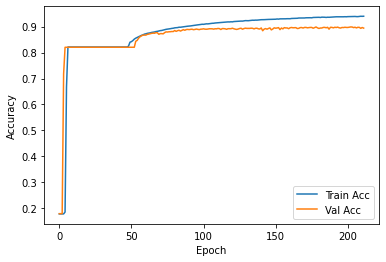

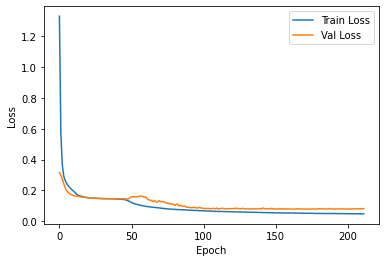

Time taken 239.63160490989685
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              multiple                  1952      
_________________________________________________________________
conv1d_1 (Conv1D)            multiple                  10304     
_________________________________________________________________
batch_normalization (BatchNo multiple                  256       
_________________________________________________________________
conv1d_2 (Conv1D)            multiple                  6176      
_________________________________________________________________
batch_normalization_1 (Batch multiple                  128       
_________________________________________________________________
conv1d_3 (Conv1D)            multiple                  33        
_________________________________________________________________
batch_normalization_2 (Bat

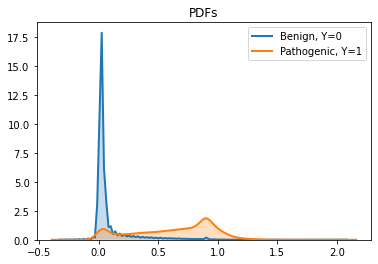

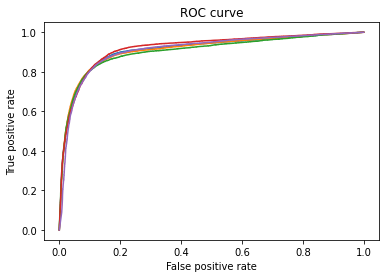

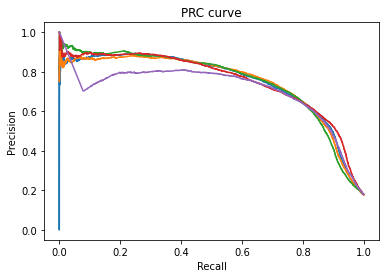

Time taken for this model 1174.3671402931213
===============Finished===============
==========Starting for h = 2==========
========Cross Validation: 1/5=========
Epoch 1/1000
23/23 - 2s - loss: 0.8731 - accuracy: 0.1797 - val_loss: 0.3127 - val_accuracy: 0.1798
Epoch 2/1000
23/23 - 1s - loss: 0.3616 - accuracy: 0.1799 - val_loss: 0.3663 - val_accuracy: 0.1791
Epoch 3/1000
23/23 - 1s - loss: 0.2572 - accuracy: 0.4511 - val_loss: 0.3399 - val_accuracy: 0.1791
Epoch 4/1000
23/23 - 1s - loss: 0.1925 - accuracy: 0.8270 - val_loss: 0.2983 - val_accuracy: 0.1791
Epoch 5/1000
23/23 - 1s - loss: 0.1598 - accuracy: 0.8302 - val_loss: 0.2655 - val_accuracy: 0.1791
Epoch 6/1000
23/23 - 1s - loss: 0.1462 - accuracy: 0.8306 - val_loss: 0.2368 - val_accuracy: 0.8204
Epoch 7/1000
23/23 - 1s - loss: 0.1399 - accuracy: 0.8338 - val_loss: 0.2131 - val_accuracy: 0.8209
Epoch 8/1000
23/23 - 1s - loss: 0.1355 - accuracy: 0.8366 - val_loss: 0.1952 - val_accuracy: 0.8209
Epoch 9/1000
23/23 - 1s - loss: 0.1316

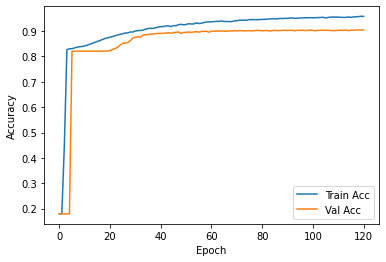

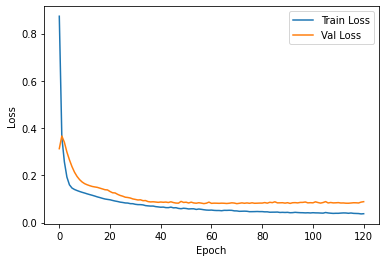

Time taken 191.9299201965332
========Cross Validation: 2/5=========
Epoch 1/1000
23/23 - 2s - loss: 1.2555 - accuracy: 0.1792 - val_loss: 0.2895 - val_accuracy: 0.1773
Epoch 2/1000
23/23 - 1s - loss: 0.5344 - accuracy: 0.1792 - val_loss: 0.3616 - val_accuracy: 0.1773
Epoch 3/1000
23/23 - 1s - loss: 0.3712 - accuracy: 0.1792 - val_loss: 0.4219 - val_accuracy: 0.1773
Epoch 4/1000
23/23 - 1s - loss: 0.2717 - accuracy: 0.3227 - val_loss: 0.4002 - val_accuracy: 0.1773
Epoch 5/1000
23/23 - 1s - loss: 0.2039 - accuracy: 0.8164 - val_loss: 0.3594 - val_accuracy: 0.1773
Epoch 6/1000
23/23 - 1s - loss: 0.1667 - accuracy: 0.8208 - val_loss: 0.3164 - val_accuracy: 0.1773
Epoch 7/1000
23/23 - 1s - loss: 0.1542 - accuracy: 0.8208 - val_loss: 0.2788 - val_accuracy: 0.1773
Epoch 8/1000
23/23 - 1s - loss: 0.1504 - accuracy: 0.8208 - val_loss: 0.2498 - val_accuracy: 0.5573
Epoch 9/1000
23/23 - 1s - loss: 0.1479 - accuracy: 0.8208 - val_loss: 0.2271 - val_accuracy: 0.8227
Epoch 10/1000
23/23 - 1s - loss:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


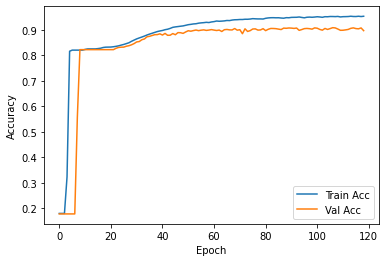

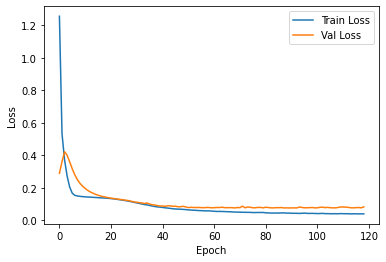

Time taken 187.2382035255432
========Cross Validation: 3/5=========
Epoch 1/1000
23/23 - 2s - loss: 0.9619 - accuracy: 0.1786 - val_loss: 0.3260 - val_accuracy: 0.1799
Epoch 2/1000
23/23 - 1s - loss: 0.4132 - accuracy: 0.1786 - val_loss: 0.4172 - val_accuracy: 0.1799
Epoch 3/1000
23/23 - 1s - loss: 0.3111 - accuracy: 0.1787 - val_loss: 0.4320 - val_accuracy: 0.1799
Epoch 4/1000
23/23 - 1s - loss: 0.2493 - accuracy: 0.5104 - val_loss: 0.3999 - val_accuracy: 0.1799
Epoch 5/1000
23/23 - 1s - loss: 0.2061 - accuracy: 0.8210 - val_loss: 0.3593 - val_accuracy: 0.1799
Epoch 6/1000
23/23 - 1s - loss: 0.1768 - accuracy: 0.8223 - val_loss: 0.3248 - val_accuracy: 0.1799
Epoch 7/1000
23/23 - 1s - loss: 0.1585 - accuracy: 0.8262 - val_loss: 0.2995 - val_accuracy: 0.1799
Epoch 8/1000
23/23 - 1s - loss: 0.1477 - accuracy: 0.8285 - val_loss: 0.2833 - val_accuracy: 0.1799
Epoch 9/1000
23/23 - 1s - loss: 0.1406 - accuracy: 0.8329 - val_loss: 0.2729 - val_accuracy: 0.1799
Epoch 10/1000
23/23 - 1s - loss:

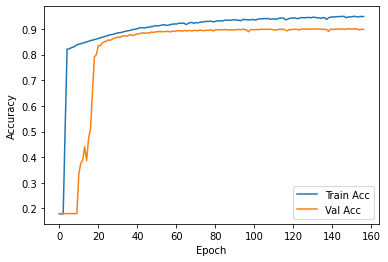

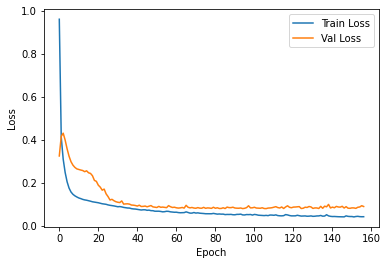

Time taken 244.67006278038025
========Cross Validation: 4/5=========
Epoch 1/1000
23/23 - 2s - loss: 1.1229 - accuracy: 0.1790 - val_loss: 0.3203 - val_accuracy: 0.1783
Epoch 2/1000
23/23 - 1s - loss: 0.4438 - accuracy: 0.1790 - val_loss: 0.4146 - val_accuracy: 0.1783
Epoch 3/1000
23/23 - 1s - loss: 0.2950 - accuracy: 0.1791 - val_loss: 0.4350 - val_accuracy: 0.1783
Epoch 4/1000
23/23 - 2s - loss: 0.2529 - accuracy: 0.4336 - val_loss: 0.4031 - val_accuracy: 0.1783
Epoch 5/1000
23/23 - 1s - loss: 0.2346 - accuracy: 0.8191 - val_loss: 0.3619 - val_accuracy: 0.1783
Epoch 6/1000
23/23 - 1s - loss: 0.2217 - accuracy: 0.8210 - val_loss: 0.3233 - val_accuracy: 0.1783
Epoch 7/1000
23/23 - 1s - loss: 0.2112 - accuracy: 0.8210 - val_loss: 0.2903 - val_accuracy: 0.1783
Epoch 8/1000
23/23 - 1s - loss: 0.2022 - accuracy: 0.8210 - val_loss: 0.2631 - val_accuracy: 0.1783
Epoch 9/1000
23/23 - 1s - loss: 0.1943 - accuracy: 0.8210 - val_loss: 0.2410 - val_accuracy: 0.8217
Epoch 10/1000
23/23 - 1s - loss

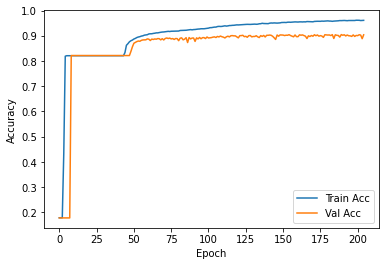

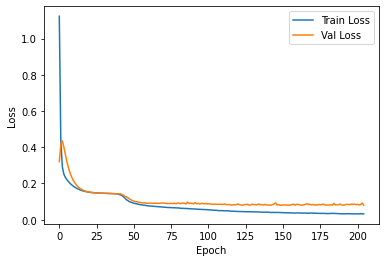

Time taken 317.04383182525635
========Cross Validation: 5/5=========
Epoch 1/1000
23/23 - 2s - loss: 0.8796 - accuracy: 0.1788 - val_loss: 0.3273 - val_accuracy: 0.1796
Epoch 2/1000
23/23 - 1s - loss: 0.3699 - accuracy: 0.1789 - val_loss: 0.4308 - val_accuracy: 0.1796
Epoch 3/1000
23/23 - 1s - loss: 0.2835 - accuracy: 0.1944 - val_loss: 0.4190 - val_accuracy: 0.1796
Epoch 4/1000
23/23 - 1s - loss: 0.2306 - accuracy: 0.7575 - val_loss: 0.3764 - val_accuracy: 0.1796
Epoch 5/1000
23/23 - 1s - loss: 0.1957 - accuracy: 0.8214 - val_loss: 0.3338 - val_accuracy: 0.1796
Epoch 6/1000
23/23 - 1s - loss: 0.1728 - accuracy: 0.8219 - val_loss: 0.2974 - val_accuracy: 0.1796
Epoch 7/1000
23/23 - 1s - loss: 0.1578 - accuracy: 0.8253 - val_loss: 0.2683 - val_accuracy: 0.1796
Epoch 8/1000
23/23 - 1s - loss: 0.1476 - accuracy: 0.8294 - val_loss: 0.2472 - val_accuracy: 0.6463
Epoch 9/1000
23/23 - 1s - loss: 0.1409 - accuracy: 0.8335 - val_loss: 0.2311 - val_accuracy: 0.8204
Epoch 10/1000
23/23 - 1s - loss

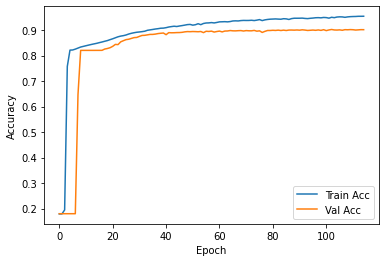

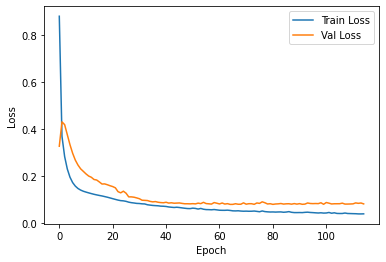

Time taken 178.77515935897827
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           multiple                  1952      
_________________________________________________________________
conv1d_21 (Conv1D)           multiple                  10304     
_________________________________________________________________
batch_normalization_15 (Batc multiple                  256       
_________________________________________________________________
conv1d_22 (Conv1D)           multiple                  20544     
_________________________________________________________________
batch_normalization_16 (Batc multiple                  256       
_________________________________________________________________
conv1d_23 (Conv1D)           multiple                  6176      
_________________________________________________________________
batch_normalization_17 (

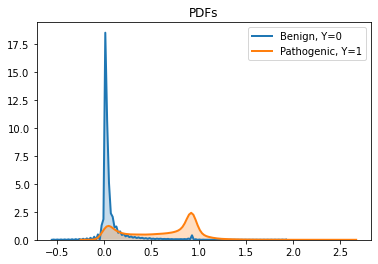

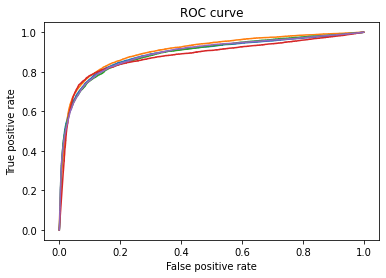

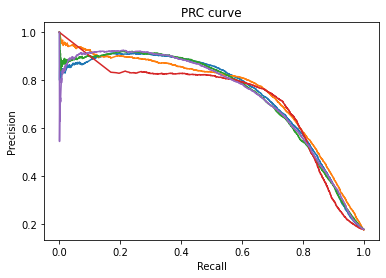

Time taken for this model 1121.1891701221466
===============Finished===============
==========Starting for h = 4==========
========Cross Validation: 1/5=========
Epoch 1/1000
23/23 - 3s - loss: 0.8736 - accuracy: 0.1861 - val_loss: 0.3972 - val_accuracy: 0.1793
Epoch 2/1000
23/23 - 2s - loss: 0.3427 - accuracy: 0.1873 - val_loss: 0.4752 - val_accuracy: 0.1791
Epoch 3/1000
23/23 - 2s - loss: 0.2395 - accuracy: 0.6345 - val_loss: 0.4565 - val_accuracy: 0.1791
Epoch 4/1000
23/23 - 2s - loss: 0.1848 - accuracy: 0.8298 - val_loss: 0.4144 - val_accuracy: 0.1791
Epoch 5/1000
23/23 - 2s - loss: 0.1563 - accuracy: 0.8323 - val_loss: 0.3823 - val_accuracy: 0.1791
Epoch 6/1000
23/23 - 2s - loss: 0.1434 - accuracy: 0.8363 - val_loss: 0.3615 - val_accuracy: 0.1791
Epoch 7/1000
23/23 - 2s - loss: 0.1367 - accuracy: 0.8382 - val_loss: 0.3435 - val_accuracy: 0.1791
Epoch 8/1000
23/23 - 2s - loss: 0.1324 - accuracy: 0.8404 - val_loss: 0.3231 - val_accuracy: 0.1791
Epoch 9/1000
23/23 - 2s - loss: 0.1285

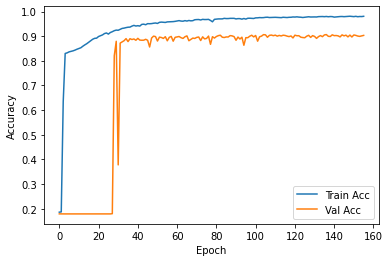

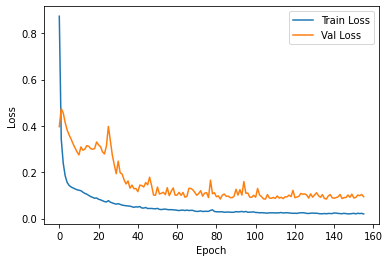

Time taken 359.6488347053528
========Cross Validation: 2/5=========
Epoch 1/1000
23/23 - 2s - loss: 0.8640 - accuracy: 0.1794 - val_loss: 0.3744 - val_accuracy: 0.1773
Epoch 2/1000
23/23 - 2s - loss: 0.3324 - accuracy: 0.1797 - val_loss: 0.4355 - val_accuracy: 0.1773
Epoch 3/1000
23/23 - 2s - loss: 0.2261 - accuracy: 0.7062 - val_loss: 0.4038 - val_accuracy: 0.1773
Epoch 4/1000
23/23 - 2s - loss: 0.1754 - accuracy: 0.8208 - val_loss: 0.3541 - val_accuracy: 0.1773
Epoch 5/1000
23/23 - 2s - loss: 0.1587 - accuracy: 0.8208 - val_loss: 0.3044 - val_accuracy: 0.1773
Epoch 6/1000
23/23 - 2s - loss: 0.1555 - accuracy: 0.8208 - val_loss: 0.2681 - val_accuracy: 0.1773
Epoch 7/1000
23/23 - 2s - loss: 0.1516 - accuracy: 0.8208 - val_loss: 0.2389 - val_accuracy: 0.8227
Epoch 8/1000
23/23 - 2s - loss: 0.1489 - accuracy: 0.8236 - val_loss: 0.2115 - val_accuracy: 0.8227
Epoch 9/1000
23/23 - 2s - loss: 0.1465 - accuracy: 0.8264 - val_loss: 0.1909 - val_accuracy: 0.8227
Epoch 10/1000
23/23 - 2s - loss:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


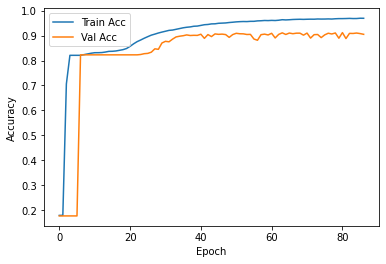

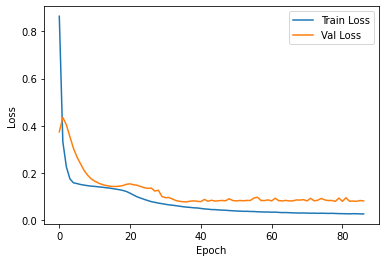

Time taken 201.88628244400024
========Cross Validation: 3/5=========
Epoch 1/1000
23/23 - 3s - loss: 0.9032 - accuracy: 0.1786 - val_loss: 0.3726 - val_accuracy: 0.1799
Epoch 2/1000
23/23 - 2s - loss: 0.3595 - accuracy: 0.1786 - val_loss: 0.4233 - val_accuracy: 0.1799
Epoch 3/1000
23/23 - 2s - loss: 0.2604 - accuracy: 0.4081 - val_loss: 0.3929 - val_accuracy: 0.1799
Epoch 4/1000
23/23 - 2s - loss: 0.2052 - accuracy: 0.8211 - val_loss: 0.3459 - val_accuracy: 0.1799
Epoch 5/1000
23/23 - 2s - loss: 0.1744 - accuracy: 0.8214 - val_loss: 0.3014 - val_accuracy: 0.1799
Epoch 6/1000
23/23 - 2s - loss: 0.1589 - accuracy: 0.8243 - val_loss: 0.2672 - val_accuracy: 0.1799
Epoch 7/1000
23/23 - 2s - loss: 0.1500 - accuracy: 0.8243 - val_loss: 0.2347 - val_accuracy: 0.8201
Epoch 8/1000
23/23 - 2s - loss: 0.1440 - accuracy: 0.8283 - val_loss: 0.2122 - val_accuracy: 0.8201
Epoch 9/1000
23/23 - 2s - loss: 0.1393 - accuracy: 0.8327 - val_loss: 0.1948 - val_accuracy: 0.8201
Epoch 10/1000
23/23 - 2s - loss

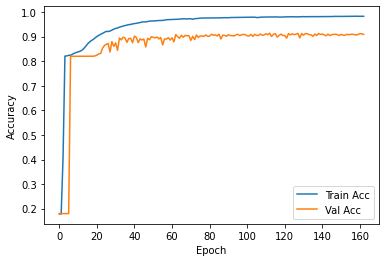

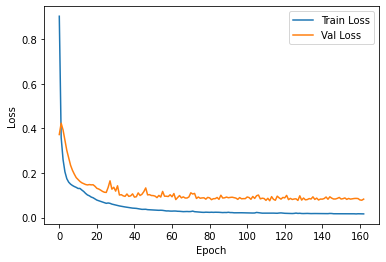

Time taken 368.9911320209503
========Cross Validation: 4/5=========
Epoch 1/1000
23/23 - 2s - loss: 0.9659 - accuracy: 0.1790 - val_loss: 0.4006 - val_accuracy: 0.1783
Epoch 2/1000
23/23 - 2s - loss: 0.3327 - accuracy: 0.2057 - val_loss: 0.4913 - val_accuracy: 0.1783
Epoch 3/1000
23/23 - 2s - loss: 0.2203 - accuracy: 0.8079 - val_loss: 0.4507 - val_accuracy: 0.1783
Epoch 4/1000
23/23 - 2s - loss: 0.2008 - accuracy: 0.8210 - val_loss: 0.3940 - val_accuracy: 0.1783
Epoch 5/1000
23/23 - 2s - loss: 0.1919 - accuracy: 0.8210 - val_loss: 0.3440 - val_accuracy: 0.1783
Epoch 6/1000
23/23 - 2s - loss: 0.1856 - accuracy: 0.8210 - val_loss: 0.3031 - val_accuracy: 0.1783
Epoch 7/1000
23/23 - 2s - loss: 0.1799 - accuracy: 0.8210 - val_loss: 0.2699 - val_accuracy: 0.1783
Epoch 8/1000
23/23 - 2s - loss: 0.1758 - accuracy: 0.8210 - val_loss: 0.2447 - val_accuracy: 0.7841
Epoch 9/1000
23/23 - 2s - loss: 0.1710 - accuracy: 0.8210 - val_loss: 0.2251 - val_accuracy: 0.8217
Epoch 10/1000
23/23 - 2s - loss:

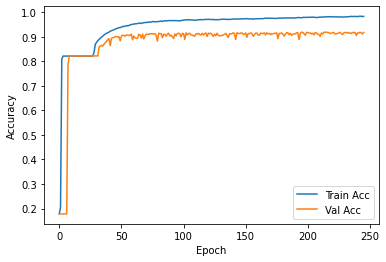

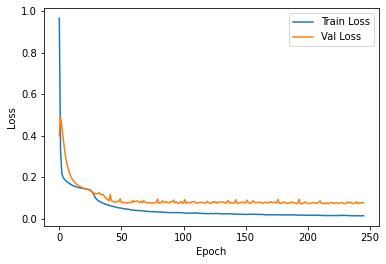

Time taken 561.4152159690857
========Cross Validation: 5/5=========
Epoch 1/1000
23/23 - 2s - loss: 0.9046 - accuracy: 0.1813 - val_loss: 0.3462 - val_accuracy: 0.1807
Epoch 2/1000
23/23 - 2s - loss: 0.3258 - accuracy: 0.1916 - val_loss: 0.3994 - val_accuracy: 0.1796
Epoch 3/1000
23/23 - 2s - loss: 0.2267 - accuracy: 0.7197 - val_loss: 0.3809 - val_accuracy: 0.1796
Epoch 4/1000
23/23 - 2s - loss: 0.1801 - accuracy: 0.8262 - val_loss: 0.3490 - val_accuracy: 0.1796
Epoch 5/1000
23/23 - 2s - loss: 0.1578 - accuracy: 0.8275 - val_loss: 0.3151 - val_accuracy: 0.1796
Epoch 6/1000
23/23 - 2s - loss: 0.1456 - accuracy: 0.8308 - val_loss: 0.2847 - val_accuracy: 0.1796
Epoch 7/1000
23/23 - 2s - loss: 0.1374 - accuracy: 0.8362 - val_loss: 0.2605 - val_accuracy: 0.1796
Epoch 8/1000
23/23 - 2s - loss: 0.1307 - accuracy: 0.8407 - val_loss: 0.2356 - val_accuracy: 0.8204
Epoch 9/1000
23/23 - 2s - loss: 0.1244 - accuracy: 0.8465 - val_loss: 0.2305 - val_accuracy: 0.8204
Epoch 10/1000
23/23 - 2s - loss:

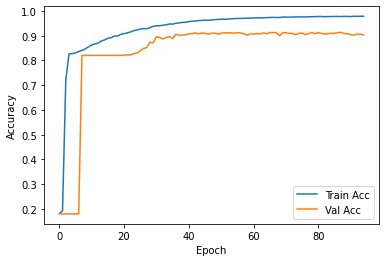

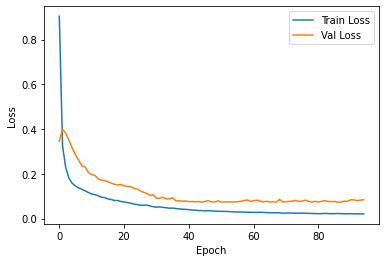

Time taken 219.39123821258545
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           multiple                  1952      
_________________________________________________________________
conv1d_46 (Conv1D)           multiple                  10304     
_________________________________________________________________
batch_normalization_35 (Batc multiple                  256       
_________________________________________________________________
conv1d_47 (Conv1D)           multiple                  20544     
_________________________________________________________________
batch_normalization_36 (Batc multiple                  256       
_________________________________________________________________
conv1d_48 (Conv1D)           multiple                  20544     
_________________________________________________________________
batch_normalization_37 

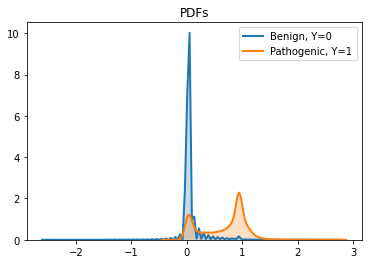

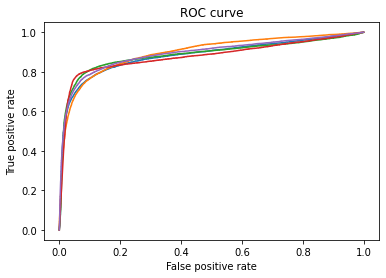

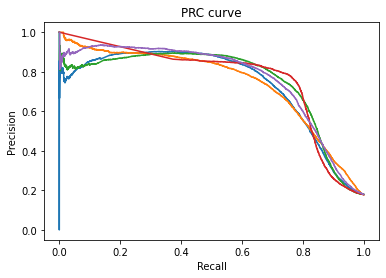

Time taken for this model 1712.8406193256378
===============Finished===============
===========Next model type============
==========Starting for h = 1==========
========Cross Validation: 1/5=========
Epoch 1/1000
23/23 - 2s - loss: 1.0425 - accuracy: 0.1788 - val_loss: 0.2938 - val_accuracy: 0.1791
Epoch 2/1000
23/23 - 1s - loss: 0.4461 - accuracy: 0.1788 - val_loss: 0.3393 - val_accuracy: 0.1791
Epoch 3/1000
23/23 - 1s - loss: 0.3349 - accuracy: 0.1788 - val_loss: 0.3457 - val_accuracy: 0.1791
Epoch 4/1000
23/23 - 1s - loss: 0.2503 - accuracy: 0.4972 - val_loss: 0.3163 - val_accuracy: 0.1791
Epoch 5/1000
23/23 - 1s - loss: 0.1947 - accuracy: 0.8212 - val_loss: 0.2775 - val_accuracy: 0.1791
Epoch 6/1000
23/23 - 1s - loss: 0.1778 - accuracy: 0.8212 - val_loss: 0.2439 - val_accuracy: 0.8242
Epoch 7/1000
23/23 - 1s - loss: 0.1715 - accuracy: 0.8212 - val_loss: 0.2177 - val_accuracy: 0.8209
Epoch 8/1000
23/23 - 1s - loss: 0.1674 - accuracy: 0.8212 - val_loss: 0.1986 - val_accuracy: 0.8209

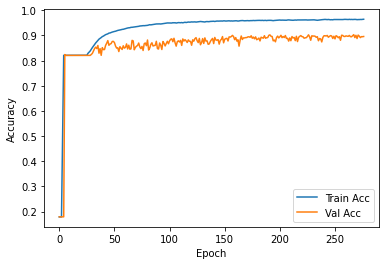

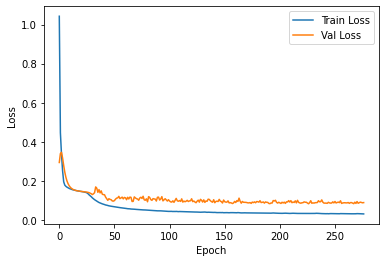

Time taken 316.95455622673035
========Cross Validation: 2/5=========
Epoch 1/1000
23/23 - 1s - loss: 1.3860 - accuracy: 0.1792 - val_loss: 0.3976 - val_accuracy: 0.1773
Epoch 2/1000
23/23 - 1s - loss: 0.7355 - accuracy: 0.1792 - val_loss: 0.2805 - val_accuracy: 0.1773
Epoch 3/1000
23/23 - 1s - loss: 0.4729 - accuracy: 0.1792 - val_loss: 0.2470 - val_accuracy: 0.6240
Epoch 4/1000
23/23 - 1s - loss: 0.3416 - accuracy: 0.1792 - val_loss: 0.2269 - val_accuracy: 0.8223
Epoch 5/1000
23/23 - 1s - loss: 0.2615 - accuracy: 0.3826 - val_loss: 0.2216 - val_accuracy: 0.8227
Epoch 6/1000
23/23 - 1s - loss: 0.2106 - accuracy: 0.8201 - val_loss: 0.2402 - val_accuracy: 0.8105
Epoch 7/1000
23/23 - 1s - loss: 0.1793 - accuracy: 0.8208 - val_loss: 0.2508 - val_accuracy: 0.4463
Epoch 8/1000
23/23 - 1s - loss: 0.1617 - accuracy: 0.8210 - val_loss: 0.2479 - val_accuracy: 0.7101
Epoch 9/1000
23/23 - 1s - loss: 0.1522 - accuracy: 0.8273 - val_loss: 0.2411 - val_accuracy: 0.8227
Epoch 10/1000
23/23 - 1s - loss

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


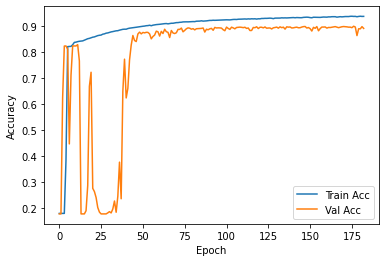

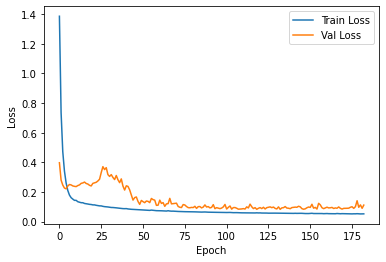

Time taken 211.27375531196594
========Cross Validation: 3/5=========
Epoch 1/1000
23/23 - 2s - loss: 1.2609 - accuracy: 0.1786 - val_loss: 0.2807 - val_accuracy: 0.1799
Epoch 2/1000
23/23 - 1s - loss: 0.5427 - accuracy: 0.1786 - val_loss: 0.2831 - val_accuracy: 0.1799
Epoch 3/1000
23/23 - 1s - loss: 0.3990 - accuracy: 0.1787 - val_loss: 0.2962 - val_accuracy: 0.1799
Epoch 4/1000
23/23 - 1s - loss: 0.3074 - accuracy: 0.1833 - val_loss: 0.2962 - val_accuracy: 0.1799
Epoch 5/1000
23/23 - 1s - loss: 0.2361 - accuracy: 0.6420 - val_loss: 0.2834 - val_accuracy: 0.1799
Epoch 6/1000
23/23 - 1s - loss: 0.1854 - accuracy: 0.8294 - val_loss: 0.2697 - val_accuracy: 0.1800
Epoch 7/1000
23/23 - 1s - loss: 0.1522 - accuracy: 0.8337 - val_loss: 0.2576 - val_accuracy: 0.1801
Epoch 8/1000
23/23 - 1s - loss: 0.1362 - accuracy: 0.8359 - val_loss: 0.2475 - val_accuracy: 0.8229
Epoch 9/1000
23/23 - 1s - loss: 0.1296 - accuracy: 0.8388 - val_loss: 0.2390 - val_accuracy: 0.8201
Epoch 10/1000
23/23 - 1s - loss

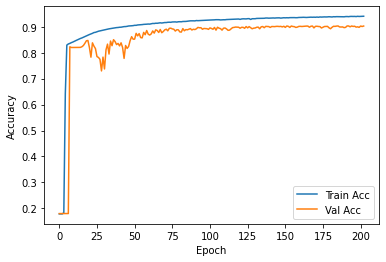

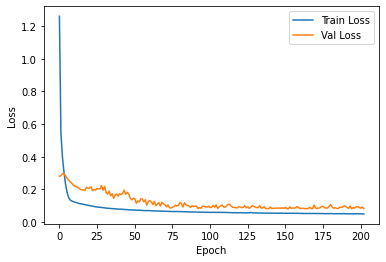

Time taken 234.5125172138214
========Cross Validation: 4/5=========
Epoch 1/1000
23/23 - 1s - loss: 1.1695 - accuracy: 0.1791 - val_loss: 0.3182 - val_accuracy: 0.1783
Epoch 2/1000
23/23 - 1s - loss: 0.5143 - accuracy: 0.1790 - val_loss: 0.2990 - val_accuracy: 0.1783
Epoch 3/1000
23/23 - 1s - loss: 0.3534 - accuracy: 0.1790 - val_loss: 0.2916 - val_accuracy: 0.1783
Epoch 4/1000
23/23 - 1s - loss: 0.2486 - accuracy: 0.5178 - val_loss: 0.2729 - val_accuracy: 0.1783
Epoch 5/1000
23/23 - 1s - loss: 0.1913 - accuracy: 0.8209 - val_loss: 0.2426 - val_accuracy: 0.8079
Epoch 6/1000
23/23 - 1s - loss: 0.1738 - accuracy: 0.8210 - val_loss: 0.2096 - val_accuracy: 0.8217
Epoch 7/1000
23/23 - 1s - loss: 0.1662 - accuracy: 0.8210 - val_loss: 0.1835 - val_accuracy: 0.8217
Epoch 8/1000
23/23 - 1s - loss: 0.1613 - accuracy: 0.8210 - val_loss: 0.1665 - val_accuracy: 0.8217
Epoch 9/1000
23/23 - 1s - loss: 0.1579 - accuracy: 0.8210 - val_loss: 0.1549 - val_accuracy: 0.8217
Epoch 10/1000
23/23 - 1s - loss:

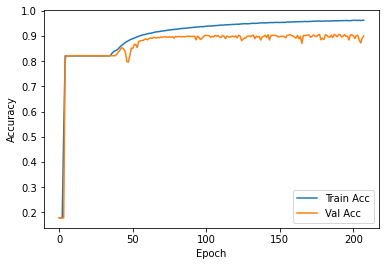

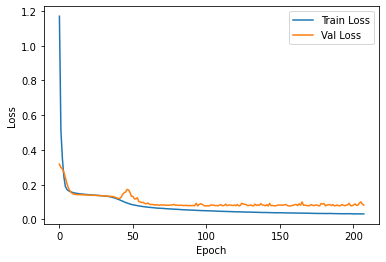

Time taken 239.53235292434692
========Cross Validation: 5/5=========
Epoch 1/1000
23/23 - 1s - loss: 1.1891 - accuracy: 0.1788 - val_loss: 0.3362 - val_accuracy: 0.1796
Epoch 2/1000
23/23 - 1s - loss: 0.5260 - accuracy: 0.1790 - val_loss: 0.3008 - val_accuracy: 0.1796
Epoch 3/1000
23/23 - 1s - loss: 0.3639 - accuracy: 0.1791 - val_loss: 0.3143 - val_accuracy: 0.1796
Epoch 4/1000
23/23 - 1s - loss: 0.2786 - accuracy: 0.2387 - val_loss: 0.2964 - val_accuracy: 0.1796
Epoch 5/1000
23/23 - 1s - loss: 0.2249 - accuracy: 0.7750 - val_loss: 0.2702 - val_accuracy: 0.1797
Epoch 6/1000
23/23 - 1s - loss: 0.1883 - accuracy: 0.8213 - val_loss: 0.2520 - val_accuracy: 0.2876
Epoch 7/1000
23/23 - 1s - loss: 0.1631 - accuracy: 0.8232 - val_loss: 0.2404 - val_accuracy: 0.8204
Epoch 8/1000
23/23 - 1s - loss: 0.1467 - accuracy: 0.8317 - val_loss: 0.2302 - val_accuracy: 0.8204
Epoch 9/1000
23/23 - 1s - loss: 0.1365 - accuracy: 0.8353 - val_loss: 0.2283 - val_accuracy: 0.8204
Epoch 10/1000
23/23 - 1s - loss

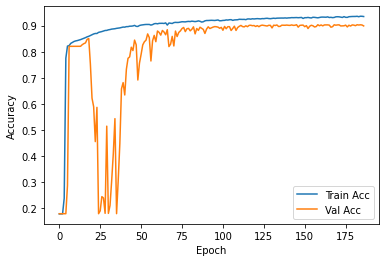

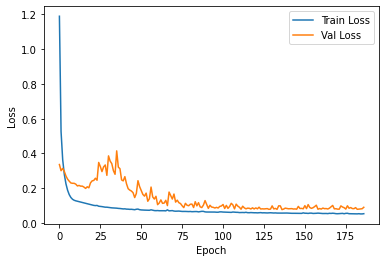

Time taken 215.76648092269897
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_80 (Conv1D)           multiple                  3232      
_________________________________________________________________
conv1d_81 (Conv1D)           multiple                  14400     
_________________________________________________________________
batch_normalization_65 (Batc multiple                  256       
_________________________________________________________________
conv1d_82 (Conv1D)           multiple                  10272     
_________________________________________________________________
batch_normalization_66 (Batc multiple                  128       
_________________________________________________________________
conv1d_83 (Conv1D)           multiple                  33        
_________________________________________________________________
batch_normalization_67 

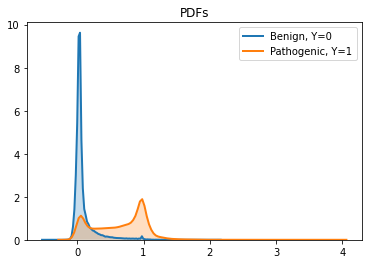

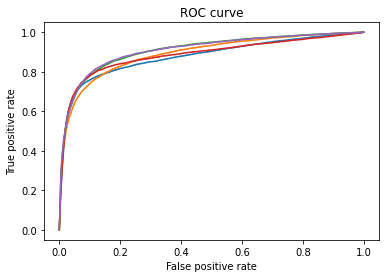

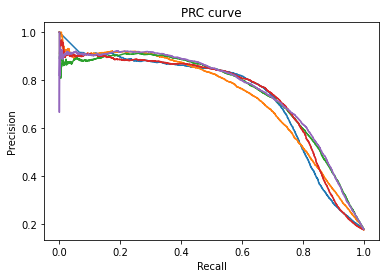

Time taken for this model 1219.835956811905
===============Finished===============
==========Starting for h = 2==========
========Cross Validation: 1/5=========
Epoch 1/1000
23/23 - 2s - loss: 0.9743 - accuracy: 0.1788 - val_loss: 0.3391 - val_accuracy: 0.1791
Epoch 2/1000
23/23 - 1s - loss: 0.4241 - accuracy: 0.1788 - val_loss: 0.4551 - val_accuracy: 0.1791
Epoch 3/1000
23/23 - 1s - loss: 0.3125 - accuracy: 0.1817 - val_loss: 0.4361 - val_accuracy: 0.1791
Epoch 4/1000
23/23 - 1s - loss: 0.2403 - accuracy: 0.6053 - val_loss: 0.3933 - val_accuracy: 0.1791
Epoch 5/1000
23/23 - 1s - loss: 0.1901 - accuracy: 0.8264 - val_loss: 0.3525 - val_accuracy: 0.1792
Epoch 6/1000
23/23 - 1s - loss: 0.1616 - accuracy: 0.8290 - val_loss: 0.3248 - val_accuracy: 0.1792
Epoch 7/1000
23/23 - 1s - loss: 0.1475 - accuracy: 0.8305 - val_loss: 0.3042 - val_accuracy: 0.1792
Epoch 8/1000
23/23 - 1s - loss: 0.1393 - accuracy: 0.8340 - val_loss: 0.2902 - val_accuracy: 0.1792
Epoch 9/1000
23/23 - 1s - loss: 0.1337 

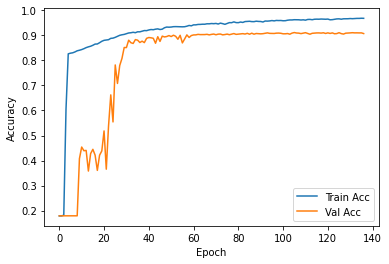

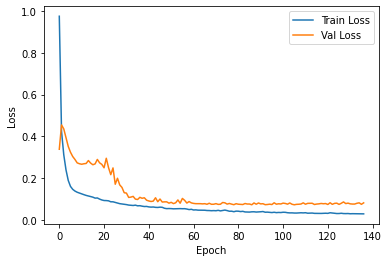

Time taken 217.73098587989807
========Cross Validation: 2/5=========
Epoch 1/1000
23/23 - 2s - loss: 0.7635 - accuracy: 0.1793 - val_loss: 0.3612 - val_accuracy: 0.1773
Epoch 2/1000
23/23 - 1s - loss: 0.3438 - accuracy: 0.1793 - val_loss: 0.4388 - val_accuracy: 0.1773
Epoch 3/1000
23/23 - 1s - loss: 0.2591 - accuracy: 0.4163 - val_loss: 0.4095 - val_accuracy: 0.1773
Epoch 4/1000
23/23 - 1s - loss: 0.2000 - accuracy: 0.8207 - val_loss: 0.3514 - val_accuracy: 0.1773
Epoch 5/1000
23/23 - 1s - loss: 0.1654 - accuracy: 0.8208 - val_loss: 0.2985 - val_accuracy: 0.1773
Epoch 6/1000
23/23 - 1s - loss: 0.1505 - accuracy: 0.8208 - val_loss: 0.2551 - val_accuracy: 0.1773
Epoch 7/1000
23/23 - 1s - loss: 0.1438 - accuracy: 0.8229 - val_loss: 0.2235 - val_accuracy: 0.8227
Epoch 8/1000
23/23 - 1s - loss: 0.1400 - accuracy: 0.8253 - val_loss: 0.2003 - val_accuracy: 0.8227
Epoch 9/1000
23/23 - 1s - loss: 0.1365 - accuracy: 0.8310 - val_loss: 0.1817 - val_accuracy: 0.8227
Epoch 10/1000
23/23 - 1s - loss

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


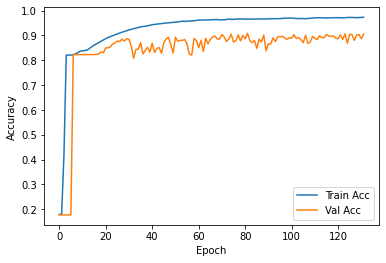

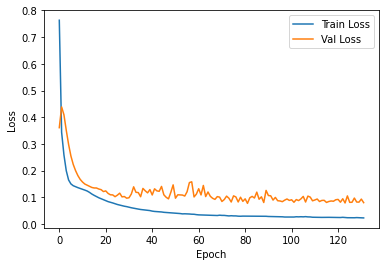

Time taken 210.40700316429138
========Cross Validation: 3/5=========
Epoch 1/1000
23/23 - 2s - loss: 0.9206 - accuracy: 0.1786 - val_loss: 0.3265 - val_accuracy: 0.1799
Epoch 2/1000
23/23 - 1s - loss: 0.3946 - accuracy: 0.1786 - val_loss: 0.4494 - val_accuracy: 0.1799
Epoch 3/1000
23/23 - 1s - loss: 0.2822 - accuracy: 0.2639 - val_loss: 0.4292 - val_accuracy: 0.1799
Epoch 4/1000
23/23 - 1s - loss: 0.2105 - accuracy: 0.8081 - val_loss: 0.3847 - val_accuracy: 0.1799
Epoch 5/1000
23/23 - 1s - loss: 0.1686 - accuracy: 0.8275 - val_loss: 0.3494 - val_accuracy: 0.1799
Epoch 6/1000
23/23 - 1s - loss: 0.1485 - accuracy: 0.8319 - val_loss: 0.3221 - val_accuracy: 0.1799
Epoch 7/1000
23/23 - 2s - loss: 0.1390 - accuracy: 0.8345 - val_loss: 0.2989 - val_accuracy: 0.1799
Epoch 8/1000
23/23 - 1s - loss: 0.1341 - accuracy: 0.8371 - val_loss: 0.2833 - val_accuracy: 0.1799
Epoch 9/1000
23/23 - 2s - loss: 0.1298 - accuracy: 0.8398 - val_loss: 0.2701 - val_accuracy: 0.1799
Epoch 10/1000
23/23 - 1s - loss

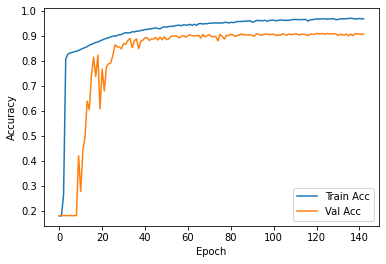

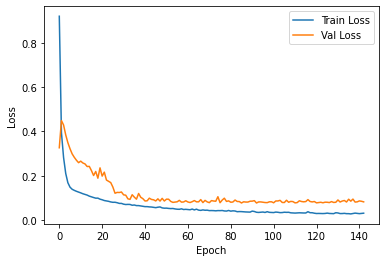

Time taken 228.42165160179138
========Cross Validation: 4/5=========
Epoch 1/1000
23/23 - 2s - loss: 0.9240 - accuracy: 0.1910 - val_loss: 0.3458 - val_accuracy: 0.1796
Epoch 2/1000
23/23 - 1s - loss: 0.3973 - accuracy: 0.1876 - val_loss: 0.4491 - val_accuracy: 0.1784
Epoch 3/1000
23/23 - 1s - loss: 0.2747 - accuracy: 0.3756 - val_loss: 0.4292 - val_accuracy: 0.1784
Epoch 4/1000
23/23 - 1s - loss: 0.1985 - accuracy: 0.8147 - val_loss: 0.3956 - val_accuracy: 0.1784
Epoch 5/1000
23/23 - 1s - loss: 0.1594 - accuracy: 0.8285 - val_loss: 0.3673 - val_accuracy: 0.1784
Epoch 6/1000
23/23 - 2s - loss: 0.1449 - accuracy: 0.8312 - val_loss: 0.3372 - val_accuracy: 0.1784
Epoch 7/1000
23/23 - 2s - loss: 0.1377 - accuracy: 0.8342 - val_loss: 0.3153 - val_accuracy: 0.1784
Epoch 8/1000
23/23 - 2s - loss: 0.1331 - accuracy: 0.8380 - val_loss: 0.2937 - val_accuracy: 0.1785
Epoch 9/1000
23/23 - 1s - loss: 0.1298 - accuracy: 0.8406 - val_loss: 0.2680 - val_accuracy: 0.1786
Epoch 10/1000
23/23 - 2s - loss

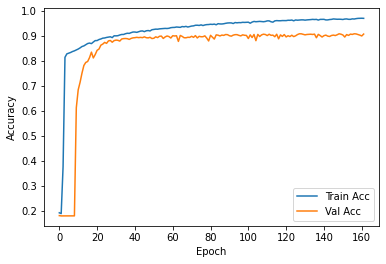

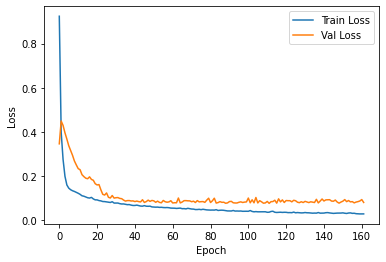

Time taken 256.28563141822815
========Cross Validation: 5/5=========
Epoch 1/1000
23/23 - 2s - loss: 1.0246 - accuracy: 0.1791 - val_loss: 0.3013 - val_accuracy: 0.1818
Epoch 2/1000
23/23 - 1s - loss: 0.4345 - accuracy: 0.1803 - val_loss: 0.4572 - val_accuracy: 0.1796
Epoch 3/1000
23/23 - 1s - loss: 0.3035 - accuracy: 0.2016 - val_loss: 0.4459 - val_accuracy: 0.1796
Epoch 4/1000
23/23 - 2s - loss: 0.2232 - accuracy: 0.7403 - val_loss: 0.4061 - val_accuracy: 0.1796
Epoch 5/1000
23/23 - 1s - loss: 0.1753 - accuracy: 0.8290 - val_loss: 0.3720 - val_accuracy: 0.1796
Epoch 6/1000
23/23 - 2s - loss: 0.1512 - accuracy: 0.8334 - val_loss: 0.3498 - val_accuracy: 0.1796
Epoch 7/1000
23/23 - 1s - loss: 0.1408 - accuracy: 0.8349 - val_loss: 0.3347 - val_accuracy: 0.1796
Epoch 8/1000
23/23 - 1s - loss: 0.1356 - accuracy: 0.8376 - val_loss: 0.3269 - val_accuracy: 0.1796
Epoch 9/1000
23/23 - 1s - loss: 0.1318 - accuracy: 0.8407 - val_loss: 0.3182 - val_accuracy: 0.1796
Epoch 10/1000
23/23 - 1s - loss

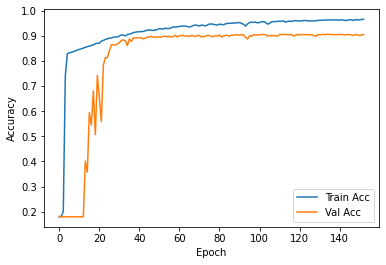

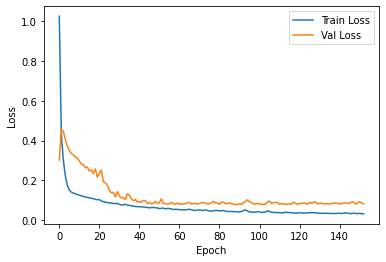

Time taken 244.06286311149597
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_100 (Conv1D)          multiple                  3232      
_________________________________________________________________
conv1d_101 (Conv1D)          multiple                  14400     
_________________________________________________________________
batch_normalization_80 (Batc multiple                  256       
_________________________________________________________________
conv1d_102 (Conv1D)          multiple                  28736     
_________________________________________________________________
batch_normalization_81 (Batc multiple                  256       
_________________________________________________________________
conv1d_103 (Conv1D)          multiple                  10272     
_________________________________________________________________
batch_normalization_82 

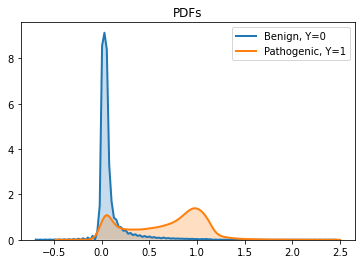

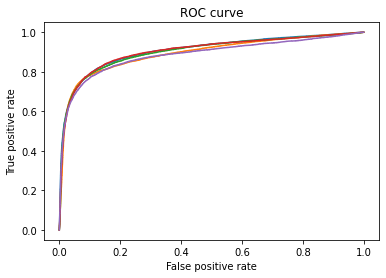

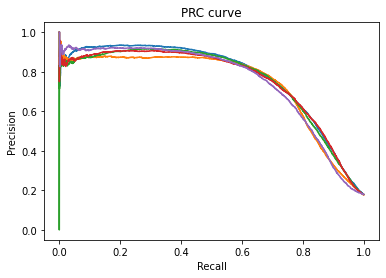

Time taken for this model 1158.397076845169
===============Finished===============
==========Starting for h = 4==========
========Cross Validation: 1/5=========
Epoch 1/1000
23/23 - 3s - loss: 0.7777 - accuracy: 0.2259 - val_loss: 0.4028 - val_accuracy: 0.1791
Epoch 2/1000
23/23 - 2s - loss: 0.3005 - accuracy: 0.3101 - val_loss: 0.4288 - val_accuracy: 0.1791
Epoch 3/1000
23/23 - 2s - loss: 0.1998 - accuracy: 0.8039 - val_loss: 0.3967 - val_accuracy: 0.1791
Epoch 4/1000
23/23 - 2s - loss: 0.1585 - accuracy: 0.8249 - val_loss: 0.3489 - val_accuracy: 0.1791
Epoch 5/1000
23/23 - 2s - loss: 0.1409 - accuracy: 0.8296 - val_loss: 0.3030 - val_accuracy: 0.1791
Epoch 6/1000
23/23 - 2s - loss: 0.1325 - accuracy: 0.8329 - val_loss: 0.2658 - val_accuracy: 0.1791
Epoch 7/1000
23/23 - 2s - loss: 0.1241 - accuracy: 0.8402 - val_loss: 0.2461 - val_accuracy: 0.6470
Epoch 8/1000
23/23 - 2s - loss: 0.1172 - accuracy: 0.8469 - val_loss: 0.2315 - val_accuracy: 0.8300
Epoch 9/1000
23/23 - 2s - loss: 0.1108 

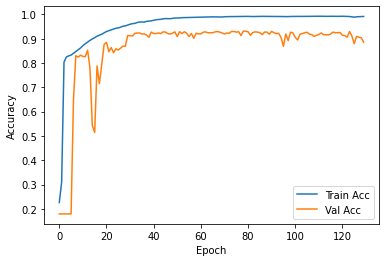

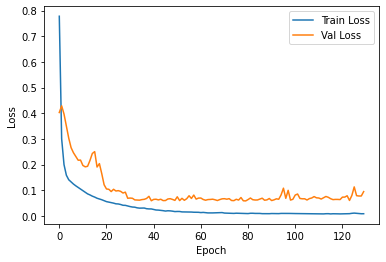

Time taken 301.23481726646423
========Cross Validation: 2/5=========
Epoch 1/1000
23/23 - 2s - loss: 0.7696 - accuracy: 0.2251 - val_loss: 0.5123 - val_accuracy: 0.1775
Epoch 2/1000
23/23 - 2s - loss: 0.3254 - accuracy: 0.2451 - val_loss: 0.5406 - val_accuracy: 0.1773
Epoch 3/1000
23/23 - 2s - loss: 0.2164 - accuracy: 0.7806 - val_loss: 0.4948 - val_accuracy: 0.1773
Epoch 4/1000
23/23 - 2s - loss: 0.1724 - accuracy: 0.8243 - val_loss: 0.4504 - val_accuracy: 0.1773
Epoch 5/1000
23/23 - 2s - loss: 0.1499 - accuracy: 0.8303 - val_loss: 0.4272 - val_accuracy: 0.1773
Epoch 6/1000
23/23 - 2s - loss: 0.1367 - accuracy: 0.8356 - val_loss: 0.4229 - val_accuracy: 0.1773
Epoch 7/1000
23/23 - 2s - loss: 0.1310 - accuracy: 0.8406 - val_loss: 0.4270 - val_accuracy: 0.1773
Epoch 8/1000
23/23 - 2s - loss: 0.1213 - accuracy: 0.8490 - val_loss: 0.4405 - val_accuracy: 0.1773
Epoch 9/1000
23/23 - 2s - loss: 0.1128 - accuracy: 0.8585 - val_loss: 0.4570 - val_accuracy: 0.1773
Epoch 10/1000
23/23 - 2s - loss

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


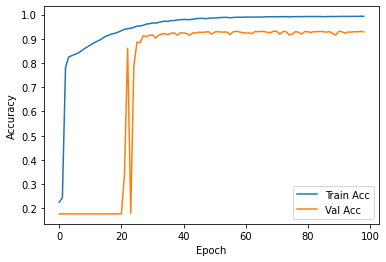

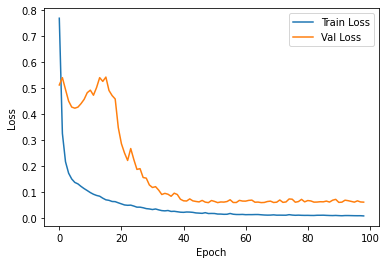

Time taken 230.62973046302795
========Cross Validation: 3/5=========
Epoch 1/1000
23/23 - 3s - loss: 0.6441 - accuracy: 0.2061 - val_loss: 0.3671 - val_accuracy: 0.1799
Epoch 2/1000
23/23 - 2s - loss: 0.2588 - accuracy: 0.5362 - val_loss: 0.4005 - val_accuracy: 0.1799
Epoch 3/1000
23/23 - 2s - loss: 0.1771 - accuracy: 0.8208 - val_loss: 0.3525 - val_accuracy: 0.1799
Epoch 4/1000
23/23 - 2s - loss: 0.1484 - accuracy: 0.8259 - val_loss: 0.3030 - val_accuracy: 0.1799
Epoch 5/1000
23/23 - 2s - loss: 0.1362 - accuracy: 0.8310 - val_loss: 0.2562 - val_accuracy: 0.1799
Epoch 6/1000
23/23 - 2s - loss: 0.1270 - accuracy: 0.8384 - val_loss: 0.2266 - val_accuracy: 0.8201
Epoch 7/1000
23/23 - 2s - loss: 0.1190 - accuracy: 0.8447 - val_loss: 0.2091 - val_accuracy: 0.8201
Epoch 8/1000
23/23 - 2s - loss: 0.1099 - accuracy: 0.8563 - val_loss: 0.1965 - val_accuracy: 0.8201
Epoch 9/1000
23/23 - 2s - loss: 0.1018 - accuracy: 0.8659 - val_loss: 0.1807 - val_accuracy: 0.8201
Epoch 10/1000
23/23 - 2s - loss

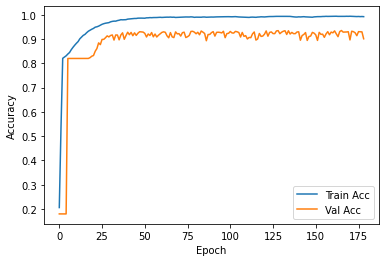

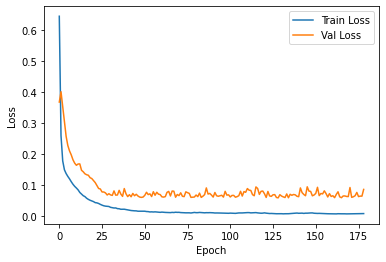

Time taken 415.1748993396759
========Cross Validation: 4/5=========
Epoch 1/1000
23/23 - 2s - loss: 0.9040 - accuracy: 0.2884 - val_loss: 0.4031 - val_accuracy: 0.1784
Epoch 2/1000
23/23 - 2s - loss: 0.4008 - accuracy: 0.2241 - val_loss: 0.5057 - val_accuracy: 0.1783
Epoch 3/1000
23/23 - 2s - loss: 0.2611 - accuracy: 0.4478 - val_loss: 0.4745 - val_accuracy: 0.1783
Epoch 4/1000
23/23 - 2s - loss: 0.1954 - accuracy: 0.8031 - val_loss: 0.4300 - val_accuracy: 0.1783
Epoch 5/1000
23/23 - 2s - loss: 0.1615 - accuracy: 0.8274 - val_loss: 0.3918 - val_accuracy: 0.1783
Epoch 6/1000
23/23 - 2s - loss: 0.1410 - accuracy: 0.8356 - val_loss: 0.3662 - val_accuracy: 0.1783
Epoch 7/1000
23/23 - 2s - loss: 0.1277 - accuracy: 0.8423 - val_loss: 0.3549 - val_accuracy: 0.1783
Epoch 8/1000
23/23 - 2s - loss: 0.1184 - accuracy: 0.8501 - val_loss: 0.3462 - val_accuracy: 0.1783
Epoch 9/1000
23/23 - 2s - loss: 0.1099 - accuracy: 0.8587 - val_loss: 0.3442 - val_accuracy: 0.1783
Epoch 10/1000
23/23 - 2s - loss:

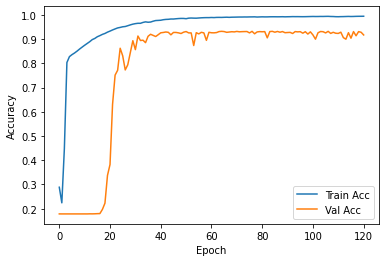

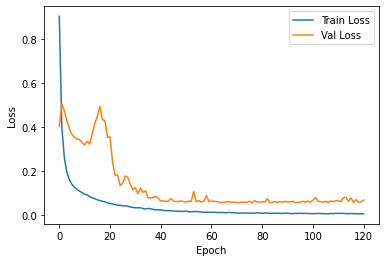

Time taken 282.3646049499512
========Cross Validation: 5/5=========
Epoch 1/1000
23/23 - 2s - loss: 0.6650 - accuracy: 0.2081 - val_loss: 0.3368 - val_accuracy: 0.1798
Epoch 2/1000
23/23 - 2s - loss: 0.2380 - accuracy: 0.6477 - val_loss: 0.3551 - val_accuracy: 0.1796
Epoch 3/1000
23/23 - 2s - loss: 0.1713 - accuracy: 0.8211 - val_loss: 0.2770 - val_accuracy: 0.1796
Epoch 4/1000
23/23 - 2s - loss: 0.1525 - accuracy: 0.8217 - val_loss: 0.2107 - val_accuracy: 0.8189
Epoch 5/1000
23/23 - 2s - loss: 0.1444 - accuracy: 0.8234 - val_loss: 0.1900 - val_accuracy: 0.8204
Epoch 6/1000
23/23 - 2s - loss: 0.1345 - accuracy: 0.8304 - val_loss: 0.1691 - val_accuracy: 0.8204
Epoch 7/1000
23/23 - 2s - loss: 0.1237 - accuracy: 0.8386 - val_loss: 0.1543 - val_accuracy: 0.8204
Epoch 8/1000
23/23 - 2s - loss: 0.1133 - accuracy: 0.8517 - val_loss: 0.1473 - val_accuracy: 0.8204
Epoch 9/1000
23/23 - 2s - loss: 0.1033 - accuracy: 0.8630 - val_loss: 0.1424 - val_accuracy: 0.8204
Epoch 10/1000
23/23 - 2s - loss:

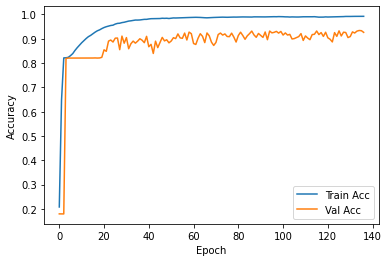

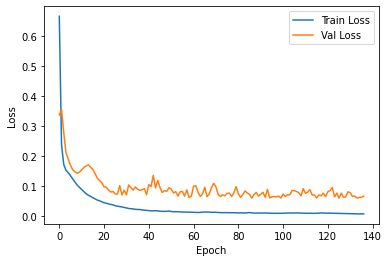

Time taken 319.14486742019653
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_125 (Conv1D)          multiple                  3232      
_________________________________________________________________
conv1d_126 (Conv1D)          multiple                  14400     
_________________________________________________________________
batch_normalization_100 (Bat multiple                  256       
_________________________________________________________________
conv1d_127 (Conv1D)          multiple                  28736     
_________________________________________________________________
batch_normalization_101 (Bat multiple                  256       
_________________________________________________________________
conv1d_128 (Conv1D)          multiple                  28736     
_________________________________________________________________
batch_normalization_102

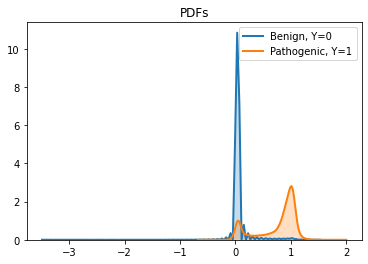

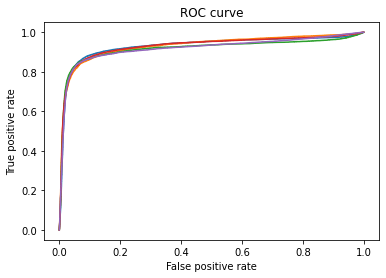

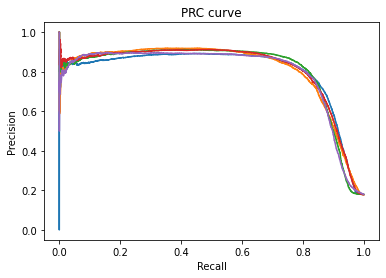

Time taken for this model 1550.0252892971039
===============Finished===============
Total time taken 7936.6570744514465
The h value for the best auc is 4 in the complex model and the corresponding auc is 0.924898686977747


In [4]:
# best_h_acc = -1  # best h value when chosen based on the validation accuracy.
# best_acc = 0
best_h_auc = -1  # best h value when chosen based on the validation auc value.
best_auc = 0
best_pred = ""
best_model_maker = get_model

over_all_start_time = time.time()

for model_maker in [get_model, get_model2]:
    print("===========Next model type============")
    for h in [1, 2, 4]:
        start_time = time.time()
        print("==========Starting for h =", str(h) + "==========")

        metrics = k_fold_cross_validation(h, X, Y, k=5, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping_callback], get_model=model_maker)

        print(metrics["model_summary"])

        print("Final metrics for this model")
        print("Average of the final training set accuracy over all folds =", str(metrics["avg_accuracy_train"]))
        print("Average of the final training set loss over all folds =", str(metrics["avg_loss_train"]))
        print("Average of the final validation set accuracy over all folds =", str(metrics["avg_accuracy_val"]))
        print("Average of the final validation set loss over all folds =", str(metrics["avg_loss_val"]))
        print("Average of the ROC AUC over all folds =", str(metrics["avg_roc_auc"]))
        pred = metrics["predictions"]
        print("Genes with both pathogenic and benign mutations:")
        print(genes_with_both(gene_ids, Y, pred))
        draw_pdf(Y, pred)

        for c in metrics["roc"]: plt.plot(*c)
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.show()

        for c in metrics["prc"]: plt.plot(*c)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('PRC curve')
        plt.show()

        # if metrics["avg_accuracy_val"] > best_acc:
        #     best_h_acc = h
        #     best_acc = metrics["avg_accuracy_val"]

        if metrics["avg_roc_auc"] > best_auc:
            best_h_auc = h
            best_auc = metrics["avg_roc_auc"]
            best_pred = pred
            best_model_maker = model_maker

        print("Time taken for this model", str(time.time() - start_time))

        print("===============Finished===============")

print("Total time taken", str(time.time() - over_all_start_time))
# print("The h value for the best validation accuracy is", str(best_h_acc), "and the corresponding accuracy is", str(best_acc))
if (best_model_maker == get_model):
    print("The h value for the best auc is", str(best_h_auc), "in the simpler model and the corresponding auc is", str(best_auc))
else:
    print("The h value for the best auc is", str(best_h_auc), "in the complex model and the corresponding auc is", str(best_auc))

Now training the best model architecture using the whole data

In [0]:
# model = best_model_maker(best_h_auc)
# history = model.fit(X, Y, batch_size=batch_size, epochs=epochs)

# plt.plot(history.history['accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.show()

# plot_model(model, to_file='model.png')
# model.summary()
# model.save("model.h5")